In [103]:
import torch
import numpy as np

# Introduccion a Pytorch

Pytorch es una libreria que permite trabajar con vectores y matrices de muchas dimensiones.

En ese sentido es muy parecido a Numpy. En numpy a los vectores son llamados arrays. En pytorch se los llama tensores.

In [116]:
b = torch.tensor([[[1.,2.,4.],[3.,4.,7.]],[[1.,2.,1.],[3.,4.,4.]]])
b

tensor([[[1., 2., 4.],
         [3., 4., 7.]],

        [[1., 2., 1.],
         [3., 4., 4.]]])

In [117]:
b.shape

torch.Size([2, 2, 3])

In [118]:
a = torch.tensor([[1.,2.],[3.,4.]])
a

tensor([[1., 2.],
        [3., 4.]])

In [119]:
a.shape

torch.Size([2, 2])

El shape del tensor es una lista del tamano de cada dimension. Si trabajamos con matrices (como comumnmente se llama a los vectores 2D), cada "fila" tiene la misma longitud: no hay una fila mas corta que otra.

Lo mismo vale para mas dimensiones. No podemos hacer:

In [122]:
torch.tensor([[1.,2.],[3.]])

ValueError: expected sequence of length 2 at dim 1 (got 1)

## Que introduce de nuevo pytorch sobre numpy
Esencialmente dos cosas:
- Paralelizacion en GPU
- Calculo automatico de derivadas (gradiente)

Estas funciones son muy deseables cuando trabajamos con redes neuronales. Aunque tambien hay librerias de, por ejemplo, algebra lineal que han aprovechado esto para ser escritas sobre pytorch y funcionar eficientemente.

Pytorch tambien provee muchas de las funcionalidades necesarias para definir una red y entrenarla.

Con la siguiente funcion podemos ver si tenemos una GPU disponible en nuestro sistema

In [123]:
torch.cuda.is_available()

False

Podemos comparar la velocidad entre ejecutar algo en CPU o usando GPU (si tenemos).

Pytorch requiere mover explicitamente los tensores a la GPU, se puede hacer facilmente mediante el metodo .cuda()

(Si se operan vectores que estan en la GPU con vectores que estan en la GPU causara un error)

In [124]:
%%timeit
A = torch.rand(1000,1000)
B = torch.rand(1000,1000)
A@B

85.2 ms ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [86]:
%%timeit
if torch.cuda.is_available():
    A = A.cuda()
    B = B.cuda()
    A@B

636 ns ± 3.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


#### Ejercicio Opcional 1

Ejecutar el codigo anterior en una GPU. Para ello se pueden utilizar las GPU de papparspace u otro proveedor cloud.

## Pytorch Autograd

Pytorch provee la funcionalidad "recordar" como cada vector fue calculado con el fin de computar el gradiente.

Podemos definir vectores con ciertos valores y crear otros como resultado de operar los primeros y pytorch recordara el grafo de las computaciones.

Supongamos que tenemos los vectores:

$ a = 1 $

$ b = 2 $

$ c = 0 $

Y definimos $m$, $n$ (capas intermedias), $p$ (una prediccion) y $l$ (un costo) como:

$ m = a + b $

$ n = max(b,c) $

$ p = m \times n $

$ l = p^2 $

Pytorch calculara los valores intermedios dado el valor de las hojas:

$ m = 3 $

$ n = 2 $

$ p = 6 $

$ l = 36 $

Y a la vez construira el siguiente grafo de computaciones:

![title](graph.png)

Si $a$,$b$,$c$ son nuestros parametros y queremos minimizar el costo $l$. Querremos calcular: $\large\frac{\partial l}{\partial a}$, $\large\frac{\partial l}{\partial b}$, $\large\frac{\partial l}{\partial c}$

Usando las definicion de cada valor y la regla de la cadena tenemos que:

$\large\frac{\partial l}{\partial p} = 2 \times p = 12$

$\large\frac{\partial p}{\partial m} = n = 2$

$\large\frac{\partial l}{\partial m} = \frac{\partial l}{\partial p} \times \frac{\partial p}{\partial m} = 12 \times 2 = 24$

$\large\frac{\partial p}{\partial n} = m = 3$

$\large\frac{\partial l}{\partial n} = \frac{\partial l}{\partial p} \times \frac{\partial p}{\partial n} = 12 \times 3 = 36$

$\large\frac{\partial m}{\partial a} = 1$

$\large\frac{\partial l}{\partial a} = \frac{\partial l}{\partial m} \times \frac{\partial m}{\partial a} = 24 \times 1 = 24$

$\large \frac{\partial m}{\partial b} = 1$

$\large \frac{\partial n}{\partial b} = 1$

Para el caso de $b$ usamos la red de la cadena multivariada (es muy parecida a la regla del producto, de hecho la regla del producto es un caso particular de la regla de la cadena multivariada):

$\large\frac{\partial l}{\partial b} = \frac{\partial l}{\partial m} \times \frac{\partial m}{\partial b} + \frac{\partial l}{\partial n} \times \frac{\partial n}{\partial b} = 24+36 = 60$

In [125]:
a = torch.tensor([1.],requires_grad=True)
b = torch.tensor([2.],requires_grad=True)
c = torch.tensor([0.],requires_grad=True)
a,b,c

(tensor([1.], requires_grad=True),
 tensor([2.], requires_grad=True),
 tensor([0.], requires_grad=True))

In [126]:
m = a+b
n = torch.max(a,b)
m, n

(tensor([3.], grad_fn=<AddBackward0>),
 tensor([2.], grad_fn=<MaximumBackward0>))

In [127]:
p = m*n
l = p**2
p, l

(tensor([6.], grad_fn=<MulBackward0>), tensor([36.], grad_fn=<PowBackward0>))

In [128]:
m.retain_grad()
n.retain_grad()
p.retain_grad()
l.retain_grad()

l.backward()

In [130]:
l.grad, p.grad

(tensor([1.]), tensor([12.]))

In [129]:
m.grad, n.grad

(tensor([24.]), tensor([36.]))

In [131]:
a.grad, b.grad, c.grad

(tensor([24.]), tensor([60.]), None)

In [132]:
values = [[1,2,3],
          [0,1,4],
          [5,6,0]]
A = torch.tensor(values, dtype=torch.float)
A

tensor([[1., 2., 3.],
        [0., 1., 4.],
        [5., 6., 0.]])

In [12]:
A.requires_grad

False

In [18]:
A.shape

torch.Size([3, 3])

In [133]:
torch.eye(A.shape[0])

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [134]:
A_inversed = torch.inverse(A)
A_inversed

tensor([[-24.0000,  18.0000,   5.0000],
        [ 20.0000, -15.0000,  -4.0000],
        [ -5.0000,   4.0000,   1.0000]])

In [135]:
A_inversed @ A

tensor([[ 1.0000e+00, -1.9073e-06, -7.6294e-06],
        [ 4.7684e-07,  1.0000e+00,  3.8147e-06],
        [-5.9605e-07, -7.1526e-07,  1.0000e+00]])

In [137]:
def distance(X,Y):
    return torch.norm(X-Y)

def distance_to_eye(X):
    return distance(X,torch.eye(X.shape[0]))

distance_to_eye(A_inversed @ A)

tensor(9.2562e-06)

In [138]:
W = torch.rand((3,3), requires_grad=True)
W

tensor([[0.5276, 0.0136, 0.5388],
        [0.6386, 0.8579, 0.2926],
        [0.9461, 0.7783, 0.3007]], requires_grad=True)

In [141]:
A @ W

tensor([[4.6429, 4.0643, 2.0262],
        [4.4228, 3.9712, 1.4955],
        [6.4692, 5.2154, 4.4496]], grad_fn=<MmBackward0>)

In [140]:
d = distance_to_eye(A @ W)
print(d)

tensor(12.0612, grad_fn=<LinalgVectorNormBackward0>)


In [142]:
d.backward()
W.grad

tensor([[2.9839, 2.4990, 1.5980],
        [4.1890, 3.5148, 2.1760],
        [2.3729, 1.9963, 0.9999]])

In [144]:
 W.grad.zero_()

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [145]:
W.grad

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [146]:
W.data

tensor([[0.5276, 0.0136, 0.5388],
        [0.6386, 0.8579, 0.2926],
        [0.9461, 0.7783, 0.3007]])

In [158]:
for iteration in range(30000):
    d = distance_to_eye(A @ W)
    W.grad.zero_()
    d.backward()
    W.data = W.data - 0.00005 * W.grad
    if iteration % 10000 == 0:
        print(d.item())
    

0.039438143372535706
0.039437923580408096
0.039437923580408096


In [159]:
W

tensor([[-23.0651,  17.2730,   4.8100],
        [ 19.2217, -14.3948,  -3.8419],
        [ -4.8009,   3.8452,   0.9595]], requires_grad=True)

In [160]:
A_inversed

tensor([[-24.0000,  18.0000,   5.0000],
        [ 20.0000, -15.0000,  -4.0000],
        [ -5.0000,   4.0000,   1.0000]])

In [161]:
W @ A

tensor([[ 9.8508e-01,  3.0317e-03, -1.0322e-01],
        [ 1.2425e-02,  9.9748e-01,  8.5926e-02],
        [-3.1794e-03,  6.4445e-04,  9.7801e-01]], grad_fn=<MmBackward0>)

In [181]:
from torchvision import datasets, transforms

train_kwargs = {'batch_size': 32}
test_kwargs = {'batch_size': 32}


transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [187]:
for x,y in train_loader:
    break
x.shape

torch.Size([32, 1, 28, 28])

In [194]:
x.reshape(32,-1).shape

torch.Size([32, 784])

In [191]:
x[0].shape

torch.Size([1, 28, 28])

In [190]:
dataset1[3000][1]

9

In [177]:
dataset1[3000][0].shape

torch.Size([1, 28, 28])

In [182]:
tensor_image = dataset1[3000][0]

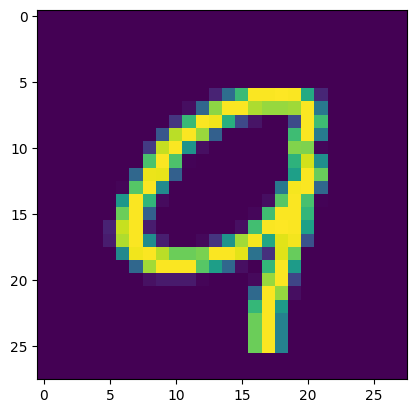

In [183]:
import matplotlib.pyplot as plt

plt.imshow(  tensor_image.permute(1, 2, 0)  )


In [ ]:
# Mueble: 0
# Repuesto: 1
# Herramienta: 2

# Mueble: [1,0,0]
# Repuesto: [0,1,0]
# Herramienta: [0,0,1]

In [ ]:
# Texto : R^size(diccionario)
# Texto[i] = cant de veces que aparece la palabra i-esima

In [ ]:
# Word : R^size(diccionario)
# Word[i] = 1 si y solo si la palabra en cuestion esta en la posicion i-esima
# "perro" si esta en la posicion 20 [0,0,0 ... , 1 , 0, 0, ... 0]

In [ ]:
texto = si queremos meter texto en una _ neuronal necesitamos representarlo como un vector

texto[i]: la palabra en la posicion i-esima
    
vector[i] = el vector de la palabra texto[i]